<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarc.csv.gz
test-unbalanced.csv  train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

In [3]:
 warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [5]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [7]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [8]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [9]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

# Визуальный анализ данных

In [10]:
y_train.value_counts(normalize=True)

0    0.500076
1    0.499924
Name: label, dtype: float64

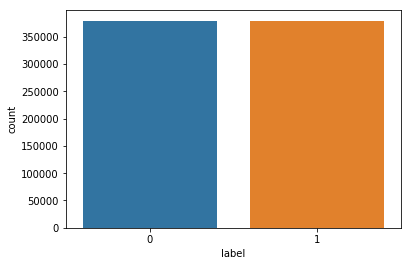

In [11]:
sns.countplot(y_train)

Целевые классы распределены равномерно.

### Облако слов

In [12]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 17, width=800, height=400)

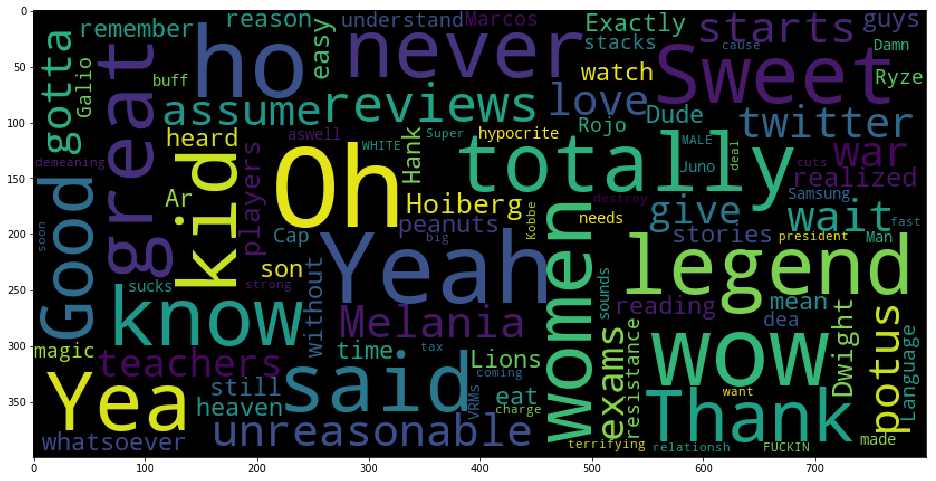

In [13]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

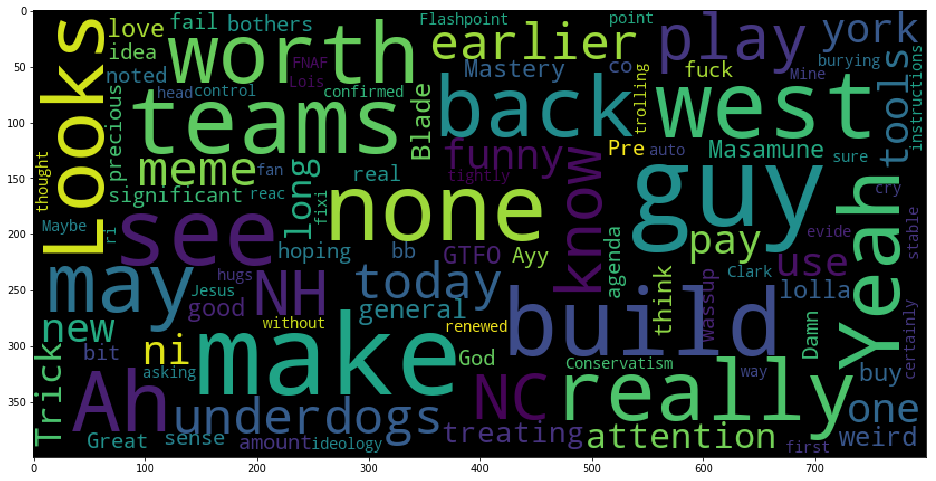

In [14]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [15]:
subreddits = train_df.groupby('subreddit')['label'].agg([np.sum])
subreddits.sort_values(by='sum', ascending=False).head(10)

,sum
subreddit,
AskReddit,26365
politics,23907
worldnews,16947
leagueoflegends,11407
pcmasterrace,10759
news,10193
funny,8099
pics,7823
todayilearned,7753


In [16]:
subreddits = train_df.groupby('author')['label'].agg([np.sum])
subreddits.sort_values(by='sum', ascending=False).head(10)

,sum
author,
Biffingston,422
pokemon_fetish,216
NeonDisease,211
ShyBiDude89,202
ivsciguy,171
mad-n-fla,159
mindlessrabble,151
Canada_girl,150
Chaoslab,126


# Подготовка датасета

## Первый подход - мешок слов

Составим словарь, посмотрим на примеры полученных слов

In [17]:
cv = CountVectorizer()
cv.fit(train_texts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
len(cv.vocabulary_)

143306

In [19]:
cv.get_feature_names()[143250:143260]

['zvz',
 'zwaagster',
 'zwaaien',
 'zwaar',
 'zware',
 'zwednesday',
 'zweer',
 'zwei',
 'zweihander',
 'zweistein']

Закодируем тренировочную и тестовую выборки

In [20]:
X_train_counts = cv.transform(train_texts)

(Информация хранится в виде разреженной матрицы для экономии памяти)

In [21]:
X_valid_counts = cv.transform(valid_texts)

## Предсказательная модель

Обучим логистическую регрессию(без настройки гиперпараметров)

In [22]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_counts, y_train)

CPU times: user 1min 39s, sys: 208 ms, total: 1min 39s
Wall time: 1min 40s


Проверка качества

In [23]:
round(logit.score(X_train_counts, y_train), 3), round(logit.score(X_valid_counts, y_valid), 3)

(0.731, 0.693)

Логистическая регрессия+кросс-валидация

In [24]:
from sklearn.linear_model import LogisticRegressionCV

In [25]:
%%time
logit_cv = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
logit_cv.fit(X_train_counts, y_train)

CPU times: user 40.5 s, sys: 24.5 s, total: 1min 4s
Wall time: 8min 55s


In [26]:
round(logit_cv.score(X_train_counts, y_train), 3), round(logit_cv.score(X_valid_counts, y_valid), 3)

(0.721, 0.695)

Подбор коэффициента регуляризации

In [27]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(train_texts, y_train)
print(text_pipe_logit.score(train_texts, y_train))
print(text_pipe_logit.score(valid_texts, y_valid))

0.731336707651841
0.6931585237480906
CPU times: user 2min 20s, sys: 414 ms, total: 2min 21s
Wall time: 2min 21s


In [28]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(train_texts, y_train)

CPU times: user 1min 56s, sys: 3.81 s, total: 2min
Wall time: 8min 4s


In [29]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.6912881111335362)

In [30]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

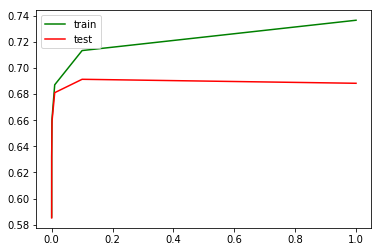

In [31]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [32]:
grid_logit.score(valid_texts, y_valid)

0.6947137644740279

In [33]:
grid_logit.score(train_texts, y_train)

0.7090224105930912

In [34]:
%%time
logit_C = LogisticRegression(C=0.1, n_jobs=-1, random_state=17)
logit_C.fit(X_train_counts,y_train)

CPU times: user 1min 26s, sys: 20.8 ms, total: 1min 26s
Wall time: 1min 27s


In [35]:
round(logit_C.score(X_train_counts, y_train), 3), round(logit_C.score(X_valid_counts, y_valid), 3)

(0.709, 0.695)

## Второй подход - Tf-Idf + logistic regression

Преобразуем данные

In [36]:
tf_vect = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=100, ngram_range=(1,2))
tf_vect.fit(train_texts)
X_train_tf = tf_vect.transform(train_texts)
X_valid_tf = tf_vect.transform(valid_texts)

In [37]:
%%time
logit = LogisticRegression(C=1, n_jobs=-1, random_state=17)
 
logit.fit(X_train_tf, y_train)

CPU times: user 9.34 s, sys: 10.8 ms, total: 9.36 s
Wall time: 9.39 s


In [38]:
round(logit.score(X_train_tf, y_train), 3), round(logit.score(X_valid_tf, y_valid), 3)

(0.675, 0.669)

In [39]:
from sklearn.pipeline import make_pipeline
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=200000, min_df=2)
logit = LogisticRegression(n_jobs=-1, random_state=17, verbose=1)
text_pipe_logit = Pipeline([('tfifd', tfidf),
                                ('logit', logit)])

text_pipe_logit.fit(train_texts, y_train)

[LibLinear]

Pipeline(memory=None,
     steps=[('tfifd', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=200000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...  penalty='l2', random_state=17, solver='warn', tol=0.0001,
          verbose=1, warm_start=False))])

In [40]:
valid_pred = text_pipe_logit.predict(valid_texts)
accuracy_score(y_valid, valid_pred)

0.7244770354658203

In [41]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

In [42]:
X_pd = pd.DataFrame(X_valid_tf.toarray())

In [43]:
show_weights(estimator=text_pipe_logit.named_steps['logit'],
                  vec=text_pipe_logit.named_steps['tfifd'])

Weight?,Feature
+9.528,yes because
+8.467,obviously
+8.412,clearly
+7.882,totally
+7.817,yeah because
+7.546,because
+6.304,how dare
+5.574,good thing
+5.506,right because
+5.346,duh


## Добавление новой фичи

In [44]:
subreddits = train_df['subreddit']
subreddits.head()

0              politics
1                   nba
2                   nfl
3    BlackPeopleTwitter
4    MaddenUltimateTeam
Name: subreddit, dtype: object

In [45]:
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [46]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=200000)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [47]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 1min 5s, sys: 1.18 s, total: 1min 6s
Wall time: 1min 7s


In [48]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 6.8 s, sys: 7.87 ms, total: 6.8 s
Wall time: 6.85 s


In [49]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [50]:
logit = LogisticRegression(C=1, n_jobs=-1, solver='lbfgs', random_state=17, verbose=1)
logit.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   37.5s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False)

In [51]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 210 ms, sys: 26.9 ms, total: 237 ms
Wall time: 236 ms


In [52]:
accuracy_score(y_valid, valid_pred)

0.7255376067496656